# Предобработка датасета

In [1]:
! pip install evaluate
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_DISABLED"] = "true"

import torch
from datasets import load_dataset
import transformers
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TrainingArguments, 
                          Trainer,
                          DataCollatorWithPadding)
import evaluate
import numpy as np
from typing import Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# torch.autograd.set_detect_anomaly(False)


2026-01-28 18:23:18.492682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769624598.707253      30 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769624598.773748      30 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769624599.287450      30 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769624599.287502      30 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769624599.287505      30 computation_placer.cc:177] computation placer alr

In [2]:

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("iitolstykh/LLMTrace_classification")
print(ds)

README.md: 0.00B [00:00, ?B/s]

train.jsonl:   0%|          | 0.00/1.40G [00:00<?, ?B/s]

valid.jsonl:   0%|          | 0.00/292M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/318M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/411440 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/86696 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/90950 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['lang', 'label', 'model', 'data_type', 'prompt_type', 'topic_id', 'text', 'prompt'],
        num_rows: 411440
    })
    validation: Dataset({
        features: ['lang', 'label', 'model', 'data_type', 'prompt_type', 'topic_id', 'text', 'prompt'],
        num_rows: 86696
    })
    test: Dataset({
        features: ['lang', 'label', 'model', 'data_type', 'prompt_type', 'topic_id', 'text', 'prompt'],
        num_rows: 90950
    })
})


In [3]:
# чекпоинт модели
checkpoint = "FacebookAI/xlm-roberta-base"
# токенизатор для модели
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# дата коллатор
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, )

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [4]:
def tokenize_example(example: Dict[str, Any]) -> Dict[str, Any]:
    """
    Функция токенизации
    --------------------------
    Parameters:
    example : datasets.DatasetDict
        датасет из библиотеки HF Datasets

     Returns:
    --------
    datasets.DatasetDict
        Токенизированный датасет
    """
    return tokenizer(
        example['text'],
        truncation = True,
        max_length = 256,
    )

In [5]:
ds['train'].column_names

['lang',
 'label',
 'model',
 'data_type',
 'prompt_type',
 'topic_id',
 'text',
 'prompt']

In [6]:
tokenized_ds = ds.map(tokenize_example, 
                      batched=True,
                      remove_columns = 
                      [name for name in ds['train'].column_names if name != 'label'],
                      # num_proc=4
                     )
tokenized_ds = tokenized_ds.class_encode_column('label')

Map:   0%|          | 0/411440 [00:00<?, ? examples/s]

Map:   0%|          | 0/86696 [00:00<?, ? examples/s]

Map:   0%|          | 0/90950 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/411440 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/86696 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/90950 [00:00<?, ? examples/s]

In [7]:
print(ds['train'][0]['label'], tokenized_ds['train'][0]['label'])


ai 0


# Метрики классификации

In [8]:
accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')
metrics_func = [accuracy, precision, recall, f1]
def compute_metrics(eval_pred):
    """
    Вычисляет метрики по предсказанию модели и меткам
    """
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    result = dict()
    for func in metrics_func:
        if func is accuracy:
            result.update(func.compute(predictions=preds, references=labels))
        else:   
            result.update(func.compute(predictions=preds, references=labels, pos_label=0))
    return result

In [9]:
compute_metrics(([[0.9, 0.1], [0.05, 0.95]], [1, 0]))

{'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}

# Обучение

In [10]:
from transformers import TrainerCallback

class DebugCallback(TrainerCallback):
    def on_step_begin(self, args, state, control, **kwargs):
        if state.global_step % 500 == 0:  # логируем каждые 10 шагов
            print(f"[DEBUG] Начало шага {state.global_step}")

    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % 500 == 0:
            print(f"[DEBUG] Завершён шаг {state.global_step}")

    def on_epoch_begin(self, args, state, control, **kwargs):
        print(f"[DEBUG] Начало эпохи {state.epoch}")

    def on_epoch_end(self, args, state, control, **kwargs):
        print(f"[DEBUG] Завершена эпоха {state.epoch}")
        print(f"    Метрики: {state.log_history[-1] if state.log_history else 'нет'}")

In [11]:


# аргументы для обучения
training_args = TrainingArguments(
    output_dir = "/kaggle/working/output/" + checkpoint + "_llm_trace_classification",
    save_strategy = 'epoch',
    eval_strategy = 'epoch',
    logging_strategy = 'epoch',
    
    learning_rate = 1e-5,
    num_train_epochs = 2,
    weight_decay = 0.001,
    fp16 = True,
    
    per_device_train_batch_size = 32,
    per_device_eval_batch_size = 32,
    gradient_accumulation_steps = 4,
    dataloader_num_workers = 2,
    logging_dir = '/kaggle/working/logs',
    logging_steps = 50,
    load_best_model_at_end = True,
    metric_for_best_model = 'f1',
    disable_tqdm=False,
    log_level = 'debug',
    log_level_replica = 'debug',
    report_to="none",
)

In [12]:
# модель
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels = 2)
demo_train =  tokenized_ds['train'].shuffle(seed=42).select(range(1024))
demo_valid =  tokenized_ds['validation'].shuffle(seed=42).select(range(1024))
trainer = Trainer(
    model = model,
    args = training_args,
    data_collator = data_collator,
    train_dataset = tokenized_ds['train'],
    eval_dataset = tokenized_ds['validation'],
    # train_dataset = demo_train,
    # eval_dataset = demo_valid,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
    callbacks=[DebugCallback()],
    
)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_30/819531934.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Using auto half precision backend


In [13]:
demo_valid.filter(lambda x : x['label'] == 0)

Filter:   0%|          | 0/1024 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 610
})

In [14]:
# import gc

# del model

# gc.collect()
# torch.cuda.empty_cache()

In [15]:
# trainer.train_dataset.class_encode_column('label')[0]

In [16]:
# trainer.train_dataset[0]

for batch in trainer.get_train_dataloader():
    print(batch)
    break

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'input_ids': tensor([[     0,    667,  24908,  ...,      1,      1,      1],
        [     0,   5892,    861,  ...,     49,  32560,      2],
        [     0,   1089, 215127,  ...,   5308,      4,      2],
        ...,
        [     0,   3858,  11514,  ...,      1,      1,      1],
        [     0,    360,     70,  ...,   6650,    299,      2],
        [     0,    589,    106,  ...,      1,      1,      1]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'), 'labels': tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')}


In [17]:
# print(torch.cuda.is_available())
# print(torch.cuda.device_count())

In [18]:
# torch.autograd.set_detect_anomaly(False)

In [19]:
# transformers.utils.logging.set_verbosity_error()
transformers.utils.logging.set_verbosity_debug()
torch.autograd.set_detect_anomaly(False)

In [20]:
trainer.train()

Currently training with a batch size of: 32
***** Running training *****
  Num examples = 411,440
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 6,430
  Number of trainable parameters = 278,045,186


[DEBUG] Начало эпохи 0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[DEBUG] Начало шага 0


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.183000,0.267258,0.907066,0.883310,0.973783,0.926343
2,0.109400,0.309746,0.905359,0.879413,0.976147,0.925259


[DEBUG] Завершён шаг 500
[DEBUG] Начало шага 500
[DEBUG] Завершён шаг 1000
[DEBUG] Начало шага 1000
[DEBUG] Завершён шаг 1500
[DEBUG] Начало шага 1500
[DEBUG] Завершён шаг 2000
[DEBUG] Начало шага 2000
[DEBUG] Завершён шаг 2500
[DEBUG] Начало шага 2500
[DEBUG] Завершён шаг 3000
[DEBUG] Начало шага 3000



***** Running Evaluation *****
  Num examples = 86696
  Batch size = 32


[DEBUG] Завершена эпоха 1.0
    Метрики: нет


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Saving model checkpoint to /kaggle/working/output/FacebookAI/xlm-roberta-base_llm_trace_classification/checkpoint-3215
Configuration saved in /kaggle/working/output/FacebookAI/xlm-roberta-base_llm_trace_classification/checkpoint-3215/config.json
Model weights saved in /kaggle/working/output/FacebookAI/xlm-roberta-base_llm_trace_classification/checkpo

[DEBUG] Начало эпохи 1.0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[DEBUG] Завершён шаг 3500
[DEBUG] Начало шага 3500
[DEBUG] Завершён шаг 4000
[DEBUG] Начало шага 4000
[DEBUG] Завершён шаг 4500
[DEBUG] Начало шага 4500
[DEBUG] Завершён шаг 5000
[DEBUG] Начало шага 5000
[DEBUG] Завершён шаг 5500
[DEBUG] Начало шага 5500
[DEBUG] Завершён шаг 6000
[DEBUG] Начало шага 6000



***** Running Evaluation *****
  Num examples = 86696
  Batch size = 32


[DEBUG] Завершена эпоха 2.0
    Метрики: {'eval_loss': 0.2672582268714905, 'eval_accuracy': 0.9070660699455569, 'eval_precision': 0.8833097965374758, 'eval_recall': 0.9737833474283079, 'eval_f1': 0.9263427343785711, 'eval_runtime': 291.2807, 'eval_samples_per_second': 297.637, 'eval_steps_per_second': 9.304, 'epoch': 1.0, 'step': 3215}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Saving model checkpoint to /kaggle/working/output/FacebookAI/xlm-roberta-base_llm_trace_classification/checkpoint-6430
Configuration saved in /kaggle/working/output/FacebookAI/xlm-roberta-base_llm_trace_classification/checkpoint-6430/config.json
Model weights saved in /kaggle/working/output/FacebookAI/xlm-roberta-base_llm_trace_classification/checkpo

TrainOutput(global_step=6430, training_loss=0.1461966269865377, metrics={'train_runtime': 9631.0237, 'train_samples_per_second': 85.441, 'train_steps_per_second': 0.668, 'total_flos': 1.082544126173184e+17, 'train_loss': 0.1461966269865377, 'epoch': 2.0})

In [21]:
logits, labels, test_metrics = trainer.predict(demo_valid)
np.unique(np.argmax(logits, axis=-1))


***** Running Prediction *****
  Num examples = 1024
  Batch size = 32
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


array([0, 1])

In [22]:
df = pd.DataFrame(trainer.state.log_history)
df_train = df[df['loss'].notna()].dropna(axis=1).reset_index()
df_eval = df[df['eval_loss'].notna()].dropna(axis=1).reset_index()
# df_train
# df_eval['eval_loss']

In [23]:
df_eval_metrics = df_eval[['epoch',  'eval_accuracy', 'eval_precision', 'eval_recall', 'eval_f1']]
df_loss = pd.concat([df_train[['epoch','loss']], df_eval[['eval_loss']]], axis=1)
# df_loss
df_eval_metrics

,epoch,eval_accuracy,eval_precision,eval_recall,eval_f1
0,1.0,0.907066,0.883310,0.973783,0.926343
1,2.0,0.905359,0.879413,0.976147,0.925259


/tmp/ipykernel_30/2642578166.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


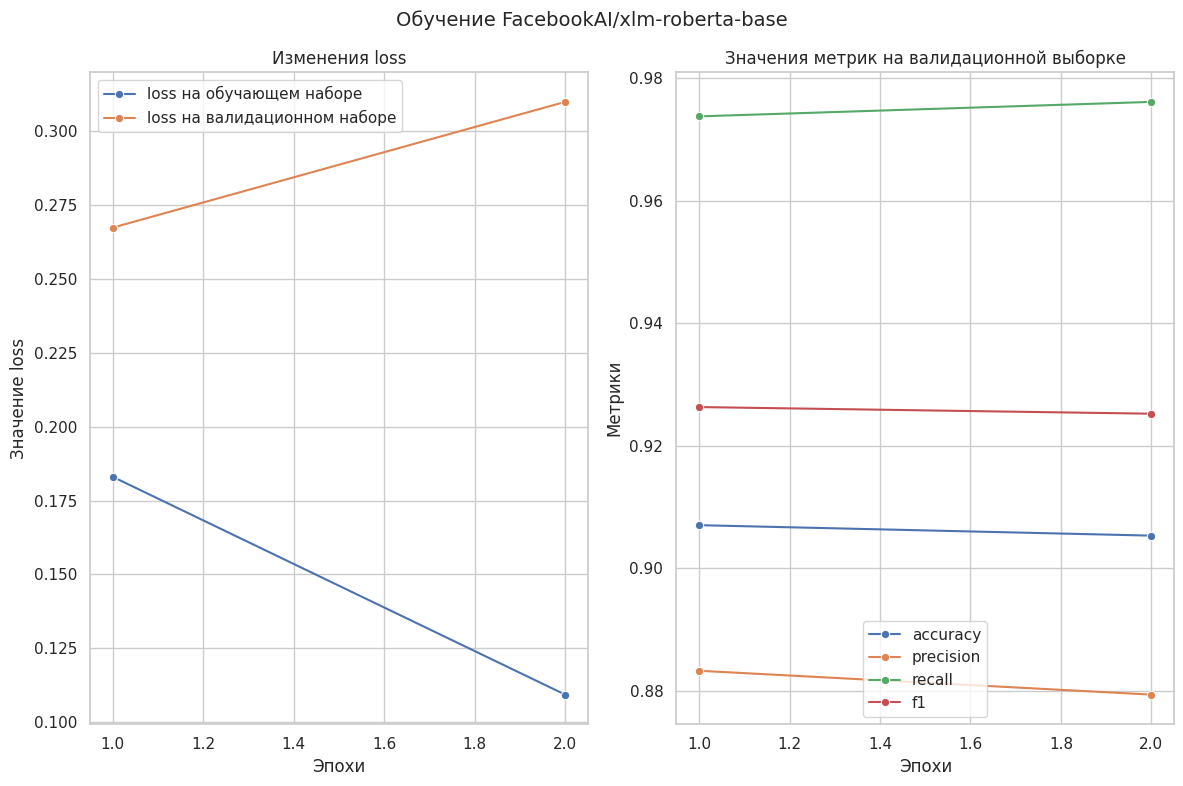

In [24]:
# Настройка общего стиля
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
plt.suptitle(f'Обучение {checkpoint}', fontsize=14, )
plt.plot()
#loss plot
ax[0].set_xlabel('Эпохи')
ax[0].set_ylabel('Значение loss')
ax[0].set_title('Изменения loss')

sns.lineplot(ax=ax[0], data=df_loss, x='epoch', y='loss', label='loss на обучающем наборе', marker='o')
sns.lineplot(ax=ax[0], data=df_loss, x='epoch', y='eval_loss', label='loss на валидационном наборе',marker='o' )
# for i in range(df_loss.shape[0]):
    # ax[0].text(x=df_loss.epoch.iloc[i], y=df_loss.loss.iloc[i] + 0.006, s=f"{df_loss.loss.iloc[i]:.4f}",fontdict=dict(color='black', size=10), horizontalalignment='center')
    # ax[0].text(x=df_loss.epoch.iloc[i], y=df_loss.eval_loss.iloc[i] - 0.006, s=f"{df_loss.eval_loss.iloc[i]:.4f}",fontdict=dict(color='black', size=10), horizontalalignment='center')


ax[0].legend()

ax[1].set_xlabel('Эпохи')
ax[1].set_ylabel('Метрики')
ax[1].set_title('Значения метрик на валидационной выборке')
# ax[1].plot('epoch','eval_accuracy', data=df_eval_metrics)
ax[1].legend()
for metric in df_eval_metrics.drop('epoch', axis=1).columns:
    sns.lineplot(ax=ax[1], data=df_eval_metrics, x='epoch', y=metric, label=metric[5:], marker='o')

plt.savefig(f'/kaggle/working/output/{checkpoint}_llm_trace_classification/train.png')
plt.tight_layout()
plt.show()

# Тест обученной модели

In [25]:
logits, labels, test_metrics = trainer.predict(tokenized_ds['test'])
# logits


***** Running Prediction *****
  Num examples = 90950
  Batch size = 32
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
import json

with open(f'/kaggle/working/output/{checkpoint}_test_metrics.json', 'w', encoding='utf-8') as f:
    json.dump(test_metrics, f, indent=4, ensure_ascii=False)

In [27]:
test_metrics

{'test_loss': 0.26820942759513855,
 'test_accuracy': 0.9081913139087411,
 'test_precision': 0.8847321369003937,
 'test_recall': 0.9735885764628148,
 'test_f1': 0.9270360013981126,
 'test_runtime': 306.079,
 'test_samples_per_second': 297.146,
 'test_steps_per_second': 9.288}

In [28]:
pred_labels = np.argmax(logits, axis=-1)

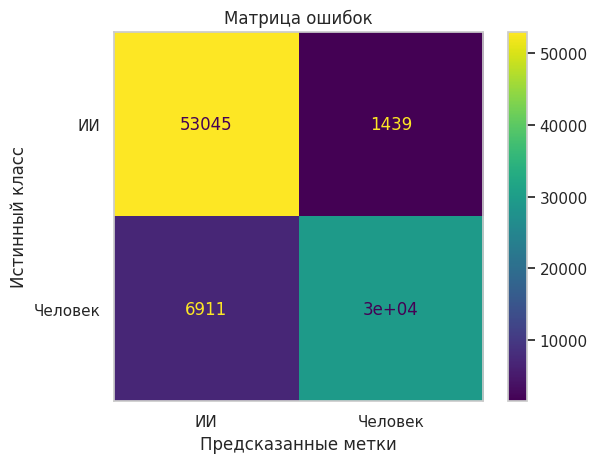

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['ИИ', 'Человек'])
disp.plot()
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.grid(False)
plt.savefig(f'/kaggle/working/output/{checkpoint}_llm_trace_classification/confusion_matrix.png')
plt.show()


# Инференс на разных языках

In [30]:
ds_test = ds['test']
ds_test = ds_test.add_column('index', list(range(len(ds_test))))

In [31]:
ds_test_ru_inds = ds_test.filter(lambda x: x['lang'] == 'ru')['index']
ds_test_eng_inds = ds_test.filter(lambda x: x['lang'] != 'ru')['index']

Filter:   0%|          | 0/90950 [00:00<?, ? examples/s]

Filter:   0%|          | 0/90950 [00:00<?, ? examples/s]

In [32]:
tokenized_ru = tokenized_ds['test'].select(ds_test_ru_inds)
tokenized_eng = tokenized_ds['test'].select(ds_test_eng_inds)
len(tokenized_ru), len(tokenized_eng)

(52521, 38429)

## На русском

In [33]:
logits, labels, test_metrics = trainer.predict(tokenized_ru)


***** Running Prediction *****
  Num examples = 52521
  Batch size = 32
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
print(f"""
Метрики (предсказание на русских отзывах):

{test_metrics}
""")


Метрики (предсказание на русских отзывах):

{'test_loss': 0.2873191237449646, 'test_accuracy': 0.9074465451914472, 'test_precision': 0.8717033511798533, 'test_recall': 0.9893261316872428, 'test_f1': 0.9267976808975228, 'test_runtime': 177.1117, 'test_samples_per_second': 296.542, 'test_steps_per_second': 9.271}



In [35]:
labels_predict = np.argmax(logits, axis=-1)
labels_predict

array([0, 0, 1, ..., 0, 0, 0])

In [36]:
import json

with open(f'/kaggle/working/output/{checkpoint}_test_metrics_ru.json', 'w', encoding='utf-8') as f:
    json.dump(test_metrics, f, indent=4, ensure_ascii=False)

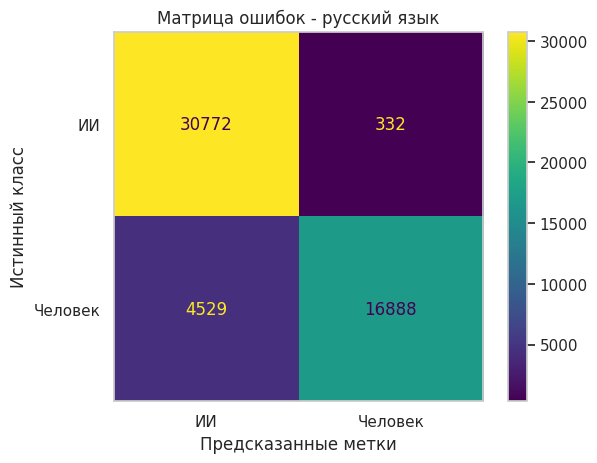

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(labels, labels_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['ИИ', 'Человек'])
disp.plot(values_format='d')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок - русский язык')
plt.grid(False)
plt.savefig(f'XLM-RoBERTa_confusion_matrix_ru.png')
plt.show()

## На английском

In [38]:
logits, preds, test_metrics = trainer.predict(tokenized_eng)


***** Running Prediction *****
  Num examples = 38429
  Batch size = 32
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
labels = preds
labels_predict = np.argmax(logits, axis=-1)
labels_predict

array([0, 1, 1, ..., 0, 1, 1])

In [40]:
import json

with open(f'/kaggle/working/output/{checkpoint}_test_metrics_eng.json', 'w', encoding='utf-8') as f:
    json.dump(test_metrics, f, indent=4, ensure_ascii=False)

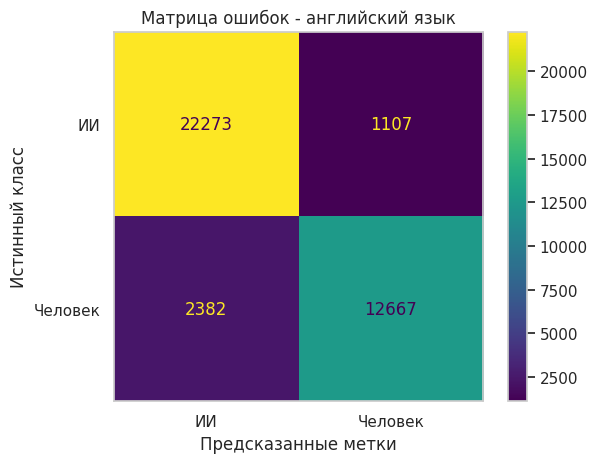

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(labels, labels_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['ИИ', 'Человек'])
disp.plot(values_format='d')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок - английский язык')
plt.grid(False)
plt.savefig(f'XLM-RoBERTa_confusion_matrix_eng.png')
plt.show()